
# Triage Efficiency

(how long it takes to SORT the scene) What record in the FRVRS log is there that shows that the scene SORT is complete?


## 0. Importing libraries and still patients data frame

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get the time that the first patient is engaged
if nu.pickle_exists('time_to_engagement_df'):
    time_to_engagement_df = nu.load_object('time_to_engagement_df')
    print(time_to_engagement_df.shape)
    df = time_to_engagement_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(674, 16)


,491,120,573,551
session_uuid,b97662b0-aa86-4317-adae-7bce0e065eb5,2bc11b9d-374b-4ab7-9d87-967931962fe8,de04bec3-9503-467c-9c49-675720c4bab0,d605640c-fde5-412f-8d33-b9b2744172ab
scene_index,0,0,1,0
logger_version,1.3,1.0,1.3,1.0
is_scene_aborted,False,False,False,False
scene_type,Orientation,Orientation,Orientation,Orientation
scene_start,5936,6810,26033,4464
last_engagement,350168,211542,398572,261135
last_patient_id,Mike_0 Root,Mike_0 Root,Mike_0 Root,Mike_0 Root
first_notice_to_last_patient,32782,16246,44465,29920
start_to_last_engagement,344232,204732,372539,256671



We are measuring the time it takes to SORT a scen. The grey-scale visualizations are from _First Responder Accuracy Using SALT during Mass-casualty Incident Simulation_, original research by Christopher W.C. Lee, MD, BASc; Shelley L. McLeod, MSc, BSc Hons; Kristine Van Aarsen, MSc, BSc; Michelle Klingel, MSc, BSc; Jeffrey M. Franc, MD, MSc, FCFP(EM), Dip. Sport Med., EMDM; and Michael B. Peddle, MD, FRCP(C), Dip. Sport Med.


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_time_to_triage_completion.png" />

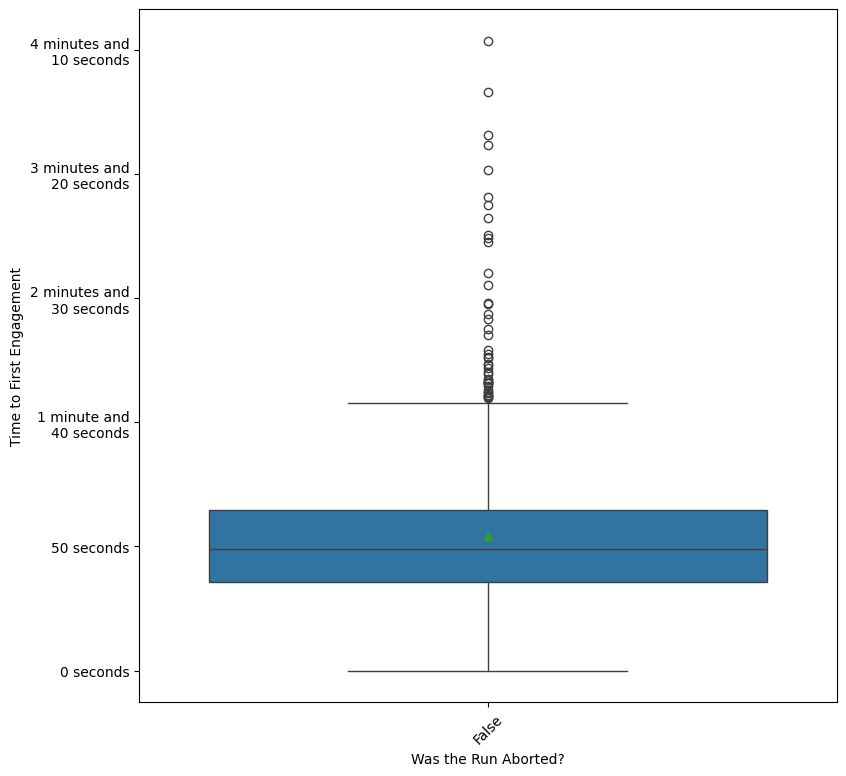

In [4]:

nu.plot_grouped_box_and_whiskers(
    time_to_engagement_df, 'is_scene_aborted', 'start_to_first_engagement', 'Was the Run Aborted?', 'Time to First Engagement', transformer_name='min'
)

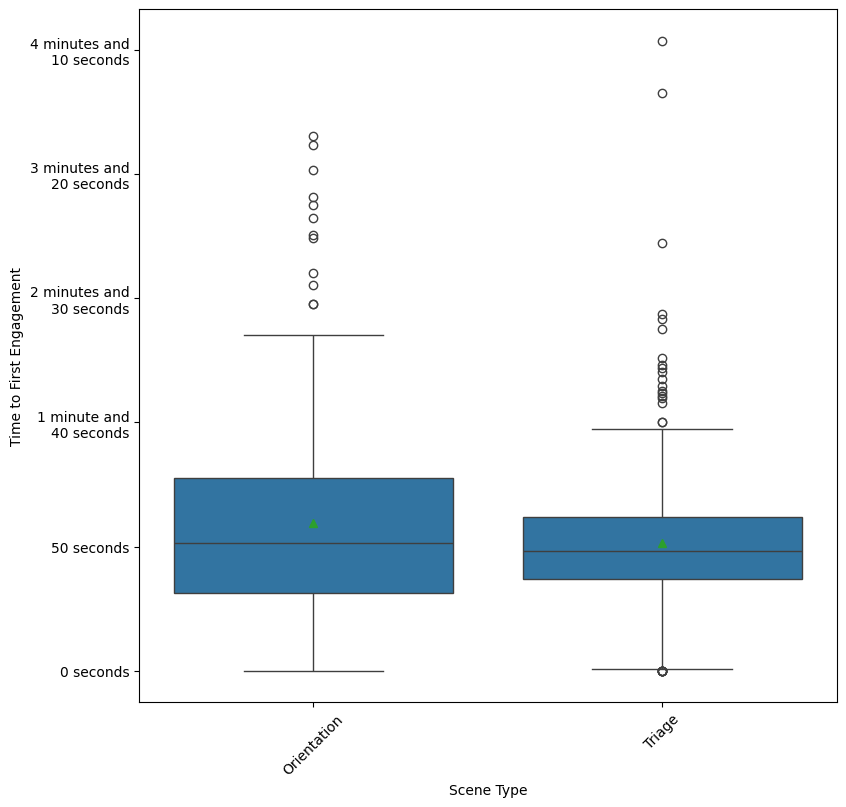

In [5]:

mask_series = (time_to_engagement_df.is_scene_aborted == False)
nu.plot_grouped_box_and_whiskers(
    time_to_engagement_df[mask_series], 'scene_type', 'start_to_first_engagement', 'Scene Type', 'Time to First Engagement', transformer_name='min'
)

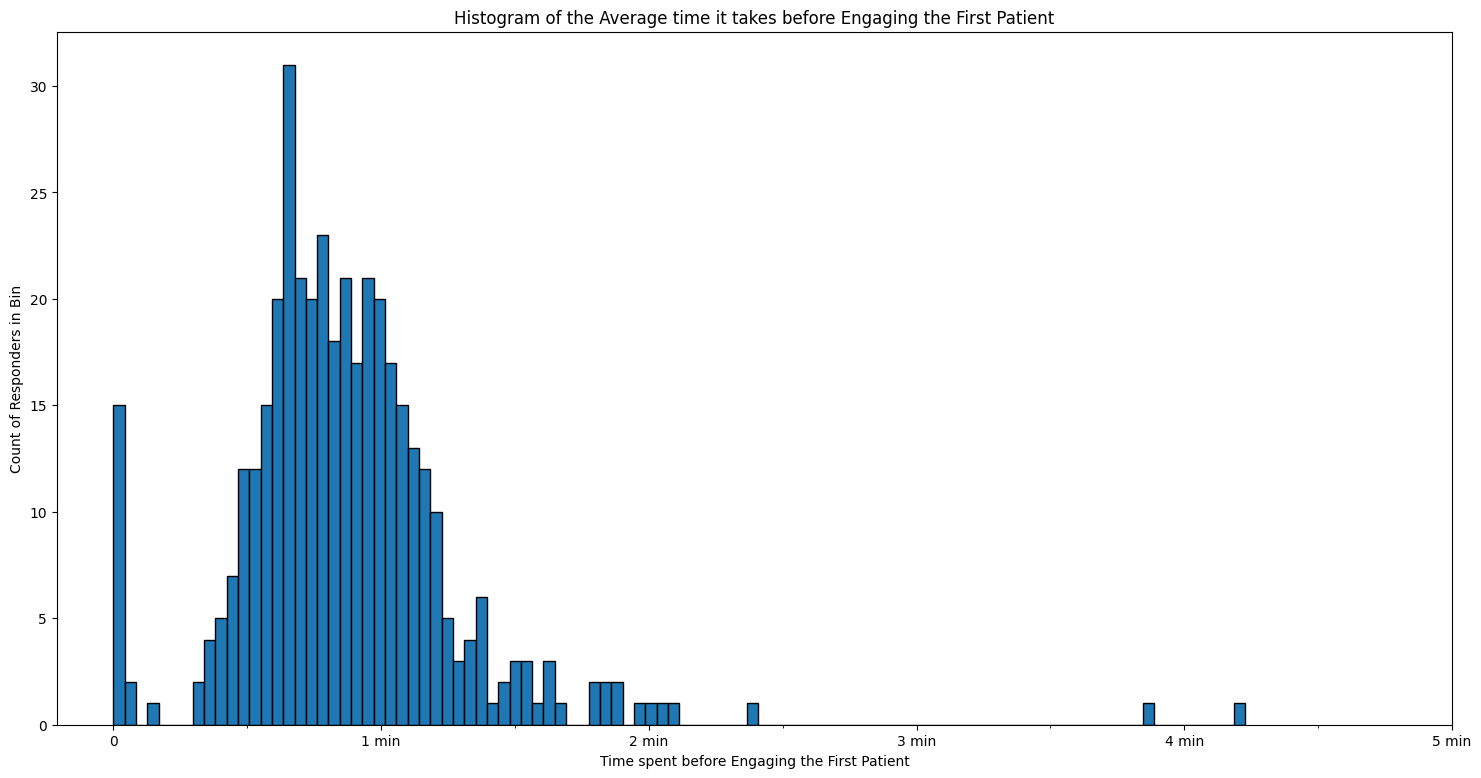

In [9]:

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
columns_list = [
    'session_uuid', 'scene_start', 'last_engagement', 'first_notice_to_last_patient', 'start_to_last_engagement', 'notice_to_last_engagement', 'first_engagement',
    'first_notice_to_first_patient', 'start_to_first_engagement', 'notice_to_first_engagement'
]
ave_first_engagement_df = time_to_engagement_df[mask_series][columns_list].groupby('session_uuid').mean()

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

# Histogram of the time that it takes to triage the scene
xlabel = 'Time spent before Engaging the First Patient'
title = 'Histogram of the Average time it takes before Engaging the First Patient'
ylabel = 'Count of Responders in Bin'
ax = nu.plot_histogram(
    ave_first_engagement_df, 'start_to_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True
)

In [8]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'start_to_first_engagement', 'notice_to_first_engagement', 'start_to_last_engagement', 'notice_to_last_engagement'
]
fu.show_time_statistics(ave_first_engagement_df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
start_to_first_engagement,51,0,49,±25,0,38,49,1:02,4:13
notice_to_first_engagement,6,0,0,±11,0,0,0,9,1:25
start_to_last_engagement,6:51,45,6:53,±2:16,45,5:30,6:53,8:13,15:49
notice_to_last_engagement,5:32,0,5:44,±2:37,0,4:22,5:44,7:14,14:25


In [8]:

# We would never have someone in the headset for 2 hours.
# Any runs longer than that 16 minutes and 40 seconds was probably an instance
# of someone taking off the headset and setting it on the ground.
# 1 second = 1000 milliseconds; 1 minute = 60 seconds
sixteen_minutes_forty_seconds = 1_000 * 60 * 16 + 1_000 * 40
delta_fn = lambda x: humanize.precisedelta(timedelta(milliseconds=x))
description = 'runs longer'
fu.show_long_runs(min_first_engagement_df, 'min_first_engagement', sixteen_minutes_forty_seconds, delta_fn, description)


These files have runs longer than 16 minutes and 40 seconds:
v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a270.csv (or v.1.0/23.05.16.1459.csv)
v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv (or v.1.0/23.05.16.1615.csv)
v.1.0/clean-9d142377-69d6-4622-958d-a29a6a0a0d21.csv (or v.1.0/23.05.09.0810.csv)
v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa46.csv (or v.1.0/23.06.12.1430.csv)


In [9]:

# The long one was probably taking off the headset and leaving it on while going to lunch.
# Can you tell me which files have the unusually long durations? Anything over 50 minutes is bogus.
# 1 second = 1000 milliseconds; 1 minute = 60 seconds
fifty_minutes = 1_000 * 60 * 50
delta_fn = lambda x: humanize.precisedelta(timedelta(milliseconds=x))
description = 'runs longer'
fu.show_long_runs(min_first_engagement_df, 'min_first_engagement', fifty_minutes, delta_fn, description)


These files have runs longer than 50 minutes:
v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a270.csv (or v.1.0/23.05.16.1459.csv)
v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv (or v.1.0/23.05.16.1615.csv)
v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa46.csv (or v.1.0/23.06.12.1430.csv)
